# Load pipeline execution result

In [1]:
import pandas as pd

from citywords.analysis import filter_mask

data_path = ENTER PATH HERE # TODO

In [2]:
det_rec_df = pd.read_csv(data_path + 'extended_center_final_df.csv')

In [3]:
mask = filter_mask(det_rec_df, rec_conf=0.3, min_len=3,
                   filter_stop=True,
                   filter_numeric=True,
                   filter_cut_text=False, cut_text_tol=5, 
                   txt_col='rec_txt', bbox_col='real_detected_bbox',
                   stop_words=('the', 'and', 'was', 'are', 'i', 'a', 'in', 'to', 'for', 'is', 'not', 'of',
                   'not', 'more', 'any', 'this', 'will', 'they'))

part_det_rec_df = det_rec_df[mask]

# Wordclouds

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

In [8]:
def make_wordcloud(topic):
    wc = WordCloud(background_color='black', max_words=2000, contour_width=5, max_font_size=500,
                   width=1280, height=720,
                   font_path='C:/Users/bigos/Documents/Master/word_cloud/wordcloud/DroidSansMono.ttf')

    words = " ".join(part_det_rec_df[part_det_rec_df['topic_cls_label'] == topic].rec_txt)
        
    wc.generate(words)

    return wc.to_image()

In [9]:
wc_imgs = {topic:make_wordcloud(topic) for topic in part_det_rec_df['topic_cls_label'].unique()}

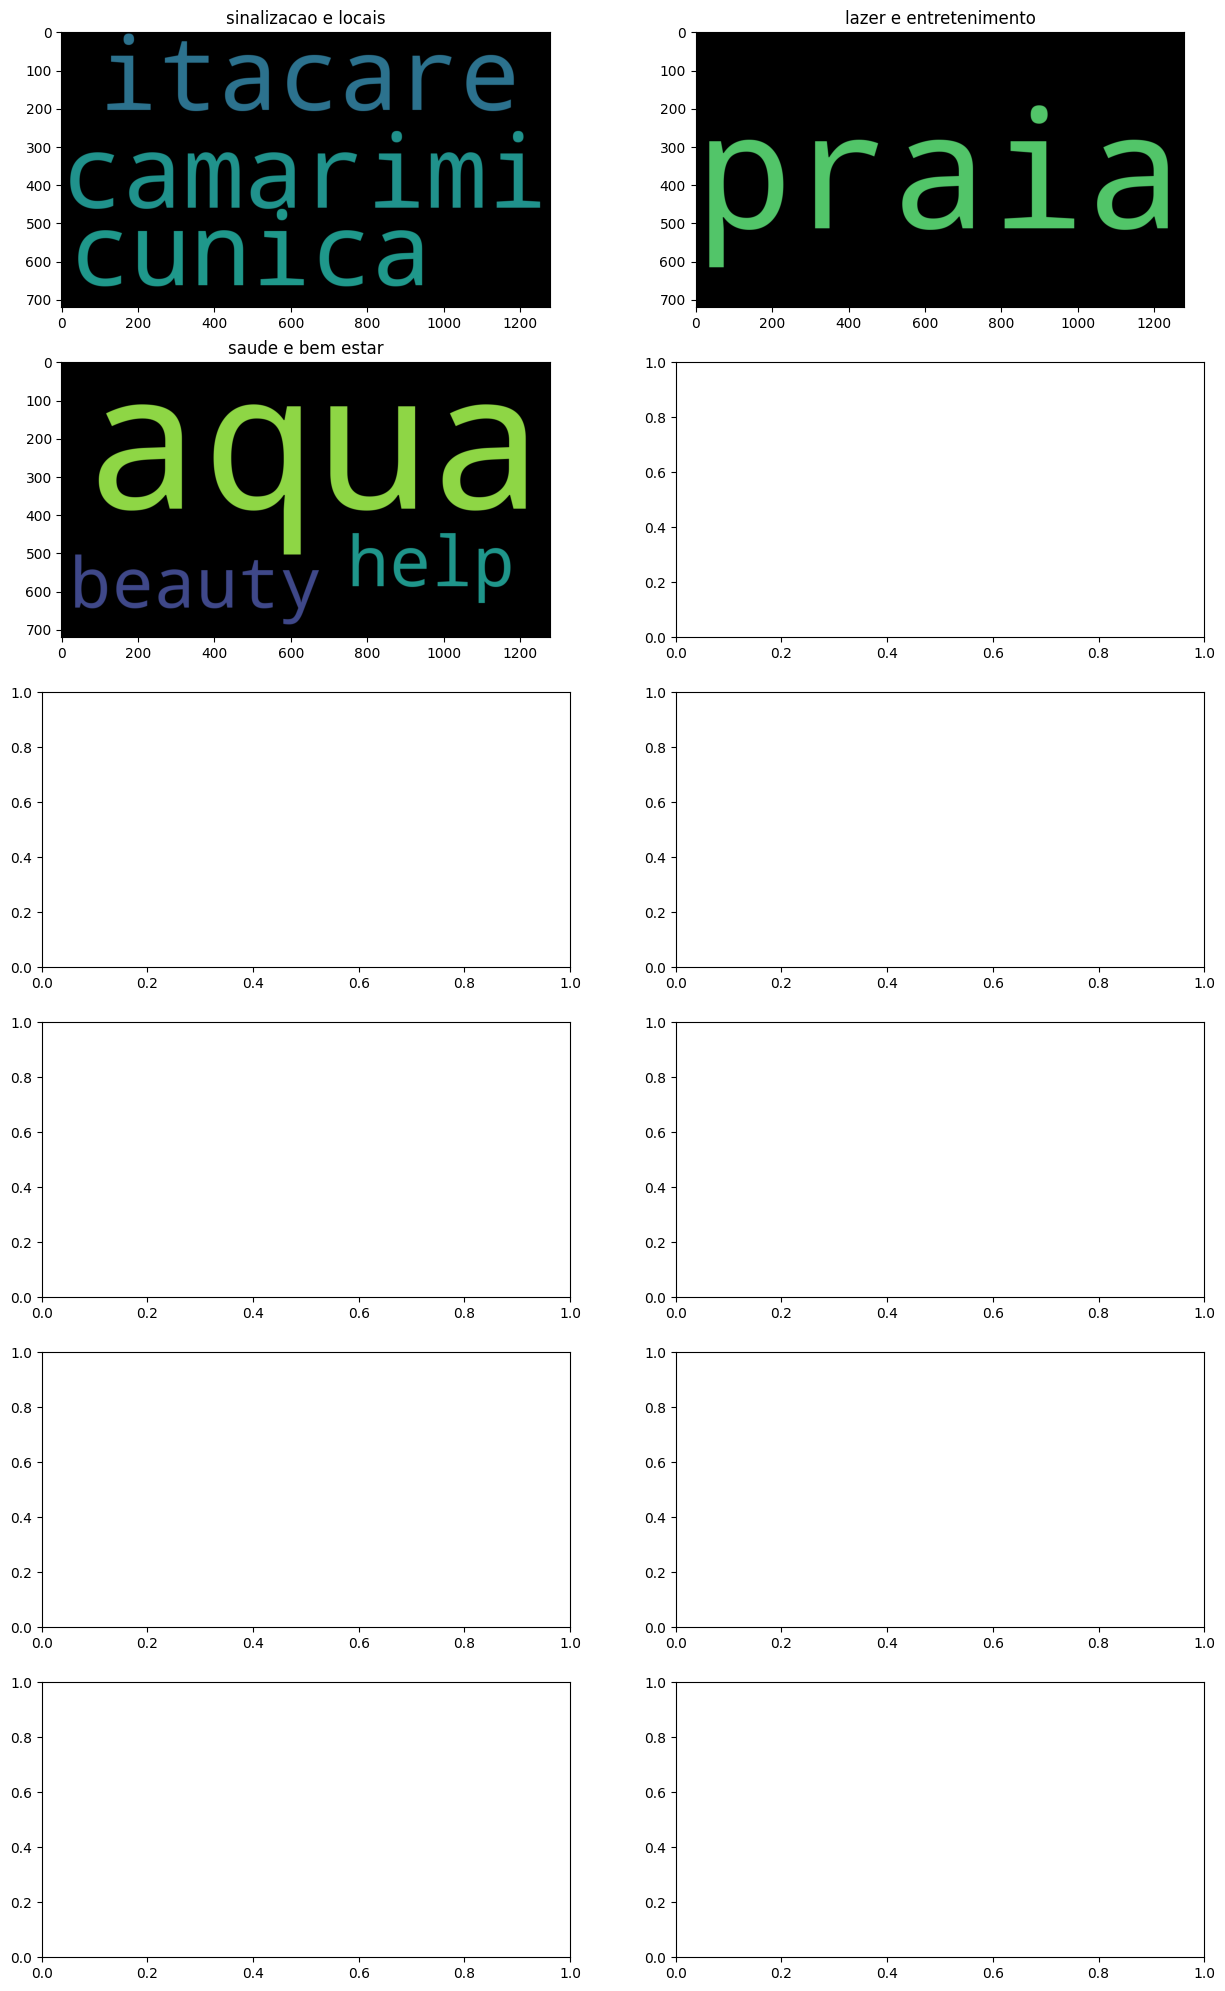

In [11]:
fig, axs = plt.subplots(6, 2, figsize=(15, 25))

i, j = 0, 0
for name, wc_img in wc_imgs.items():
    axs[i, j].imshow(wc_img)
    axs[i, j].set_title(name)

    j += 1
    if j >= 2:
        i += 1
        j = 0

# Heatmaps

In [5]:
from folium.plugins import HeatMap
from folium import Map
import folium

In [13]:
def heatmap(lats_longs, min_opacity=0.1,
            radius=10, blur=19, max_zoom=2, gradient=None, hmap=None, feature_group=''):

    lats = lats_longs[:, 0]
    lons = lats_longs[:, 1]

    if hmap is None:
        mid = (lats.mean(), lons.mean())
        hmap = Map(location=mid, zoom_start=11)
        
    
    HeatMap(list(zip(lats, lons)), name=feature_group,
                 min_opacity=min_opacity,
                 radius=radius, blur=blur,
                 max_zoom=max_zoom, gradient=gradient).add_to(folium.FeatureGroup(name=feature_group)).add_to(hmap)

    
    return hmap

In [15]:
#colormaps = ['cool', 'winter', 'autumn', 'BuPu', 'copper', 'Wistia', 'Greys', 'coolwarm']
#gradient = get_gradient_from_colormap(colormap)

overlay_map = Map(location=(part_det_rec_df.img_lat.mean(), part_det_rec_df.img_lon.mean()), zoom_start=11)

topic = 'religion'

_ = heatmap(part_det_rec_df[part_det_rec_df['topic_cls_label'] == topic][['img_lat', 'img_lon']].values,
            min_opacity=0.5, max_zoom=18, radius=25, blur=20,
            hmap=overlay_map)

overlay_map

# Property Type

In [6]:
from citywords.geosampa import land_type_map_vis

## Folium Map

In [20]:
marker_map = land_type_map_vis(str(data_path), foilum_map=None, df2restrict=det_rec_df, opacity=0.5)                              

folium.LayerControl().add_to(marker_map)

marker_map.save(f'property_type.html')

c:\Users\bigos\Documents\Master\citywords\mestrado\citywords_new\citywords\geosampa.py:176: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = landuse_df.geometry.centroid


# Proportions

In [7]:
from citywords.geosampa import restrict_by_bounds, include_landuse_in_df
from citywords.geosampa import read_land_use_df, land_type_id_to_name, group_land_types

In [22]:
landuse_df = read_land_use_df(str(data_path))

minx, miny = part_det_rec_df.img_lon.min(), part_det_rec_df.img_lat.min()
maxx, maxy = part_det_rec_df.img_lon.max(), part_det_rec_df.img_lat.max()


landuse_df = restrict_by_bounds(landuse_df, minx, miny, maxx, maxy)

landuse_df['land_type'] = land_type_id_to_name(landuse_df.tp_pred_15)
landuse_df['land_type_grouped'] = group_land_types(landuse_df.land_type)

In [23]:
landtype_eng = {'residencial': 'residential', 'comercial':'comercial', 'escolar':'school', 
                'outros':'others', 'industrial':'industrial'}

part_with_land = include_landuse_in_df(part_det_rec_df.copy(), str(data_path))

part_with_land["land_type_grouped"] = part_with_land.land_type_grouped.transform(lambda x: landtype_eng[x])

In [24]:
part_with_land.land_type_grouped.value_counts()

residential    7
comercial      1
Name: land_type_grouped, dtype: int64

In [25]:
landuse_df.land_type_grouped.value_counts()

residencial    334
comercial      237
outros          57
escolar          4
industrial       1
Name: land_type_grouped, dtype: int64

In [26]:
total_area = landuse_df.to_crs('epsg:29193').geometry.area.sum()
total_nr_texts = part_with_land.shape[0]

for land_type in landuse_df.land_type_grouped.unique():
    nr_texts = part_with_land[part_with_land.land_type_grouped == landtype_eng[land_type]].shape[0]
    area = landuse_df[landuse_df.land_type_grouped == land_type].to_crs('epsg:29193').geometry.area.sum()
    print(land_type)
    print(f'  area(km2):{area/(1000000)}')
    print(f'  area(%):{area/total_area}') 
    print(f'  texts:{nr_texts}')
    print(f'  texts(%):{nr_texts/total_nr_texts}')

residencial
  area(km2):4.804120323631725
  area(%):0.5189904562756952
  texts:7
  texts(%):0.875
comercial
  area(km2):3.2375202796412332
  area(%):0.3497502173015149
  texts:1
  texts(%):0.125
outros
  area(km2):1.162878797536455
  area(%):0.12562612030302708
  texts:0
  texts(%):0.0
industrial
  area(km2):0.005354783326745221
  area(%):0.0005784787338348994
  texts:0
  texts(%):0.0
escolar
  area(km2):0.04678991351674296
  area(%):0.005054727385928037
  texts:0
  texts(%):0.0
